In [4]:
import os
from google.colab import drive
import numpy as np

# connect the google drive
drive.mount('/content/drive')
# paths, parameters
PATH = 'drive/MyDrive/Colab_Notebooks_2/dlsnn_project'
PATH_DATA = os.path.join(PATH, 'data')
PATH_MODELS = os.path.join(PATH, 'models')
PATH_ASSETS = os.path.join(PATH, 'assets')

np.random.seed(seed=42)

# create the subdirectories
!mkdir -p $PATH_DATA
!mkdir -p $PATH_MODELS
!mkdir -p $PATH_ASSETS

Mounted at /content/drive


In [ ]:
# unzip and move the datasets
if False:
  !unzip $PATH_DATA'/AWA2.zip'
  !mv AWA2 $PATH_DATA

  !unzip $PATH_DATA'/CUB.zip'
  !mv CUB $PATH_DATA

In [ ]:
# install all the needed libraries from requirements file
!pip install -r -q $PATH'/requirements.txt'

In [4]:
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy import io, spatial
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
def load_data(dataset='AWA2', bin_att=True):
    '''
    dataset:
      'AWA2' or 'CUB' or any other ZSL dataset following the same structure and saved in PATH_DATA
    '''
    res101 = io.loadmat(os.path.join(PATH_DATA, dataset, 'res101.mat'))
    att_splits=io.loadmat(os.path.join(PATH_DATA, dataset, 'att_splits.mat'))
    if dataset=='AWA2':
        bin_att_splits=io.loadmat(os.path.join(PATH_DATA, dataset, 'binaryAtt_splits.mat'))

    # train, val, test predefined splits
    train_loc = 'train_loc'
    val_loc = 'val_loc'
    test_loc = 'test_unseen_loc'

    cl_trainval_loc = 'trainval_loc'
    cl_test_loc = 'test_seen_loc'

    # train and val splits
    train_loc = att_splits[train_loc]
    val_loc = att_splits[val_loc]

    # split the features
    feat = res101['features']
    # matlab indexing starts from 1 -> -1
    # one type of splits based on set of seen/unseen labels
    X_train = feat[:, np.squeeze(train_loc - 1)].T
    X_val = feat[:, np.squeeze(val_loc - 1)].T
    X_test_u = feat[:, np.squeeze(att_splits[test_loc] - 1)].T
    # second type of split - splits concatenation of X_train and X_val
    # but all classes are represented in both subsets
    # for classifier development
    X_trainval_s = feat[:, np.squeeze(att_splits[cl_trainval_loc]-1)].T
    X_test_s = feat[:, np.squeeze(att_splits[cl_test_loc]-1)].T

    # split the labels
    labels = res101['labels']
    # matlab indexing starts from 1 -> -1
    y_train = np.squeeze(labels[np.squeeze(train_loc - 1)])
    y_val = np.squeeze(labels[np.squeeze(val_loc - 1)])
    y_test_u = np.squeeze(labels[np.squeeze(att_splits[test_loc]-1)])

    y_trainval_s = np.squeeze(labels[np.squeeze(att_splits[cl_trainval_loc]-1)])
    y_test_s = np.squeeze(labels[np.squeeze(att_splits[cl_test_loc]-1)])

    # also the labels start with 1
    y_train -= 1
    y_val -= 1
    y_test_u -= 1
    y_trainval_s -= 1
    y_test_s -= 1

    # divide the labels to seen and unseen
    y_train_seen = np.unique(y_train)
    y_val_unseen = np.unique(y_val)
    y_test_unseen = np.unique(y_test_u)

    # divide the attributes to seen and unseen
    if dataset=='AWA2' and bin_att:
        att = bin_att_splits['att']
    elif dataset=='CUB' and bin_att:
        att = att_splits['original_att']
        att[att!=0] = 1
    else:
        att = att_splits['att']
    att_train_seen = att[:, y_train_seen]
    att_val_unseen = att[:, y_val_unseen]
    att_test_unseen = att[:, y_test_unseen]

    # create numpy arrays with attributes for all splits
    # assign corresponding attribute vector to a given label
    att_train = np.empty((y_train.shape[0], att.shape[0]))
    for i in range(y_train.shape[0]):
        att_train[i] = att[:, y_train[i]]
    att_val = np.empty((y_val.shape[0], att.shape[0]))
    for i in range(y_val.shape[0]):
        att_val[i] = att[:, y_val[i]]
    att_test_u = np.empty((y_test_u.shape[0], att.shape[0]))
    for i in range(y_test_u.shape[0]):
        att_test_u[i] = att[:, y_test_u[i]]
    att_trainval_s = np.empty((y_trainval_s.shape[0], att.shape[0]))
    for i in range(y_trainval_s.shape[0]):
        att_trainval_s[i] = att[:, y_trainval_s[i]]
    att_test_s = np.empty((y_test_s.shape[0], att.shape[0]))
    for i in range(y_test_s.shape[0]):
        att_test_s[i] = att[:, y_test_s[i]]

    # save all to dictionaries
    train = {'X': X_train, 'y': y_train, 'att': att_train}
    val = {'X': X_val, 'y': y_val, 'att': att_val}
    test_u = {'X': X_test_u, 'y': y_test_u, 'att': att_test_u}

    trainval_s = {'X': X_trainval_s, 'y': y_trainval_s, 'att': att_trainval_s}
    test_s = {'X': X_test_s, 'y': y_test_s, 'att': att_test_s}

    # get unique labels and attributes
    knn_att = att.T
    knn_y = np.arange(len(knn_att))

    # get the class names for text embedding
    class_names = att_splits['allclasses_names']

    return train, val, test_u, trainval_s, test_s, knn_att, knn_y, y_test_unseen, class_names

## AWA2 Dataset

In [ ]:
# get all the splits
train, val, test_u, trainval_s, test_s, knn_att, knn_y, y_test_unseen, class_names = load_data('AWA2', True)

In [ ]:
# split the trainval dataset
train_X, val_X, train_att, val_att, train_y, val_y = train_test_split(trainval_s['X'], trainval_s['att'], trainval_s['y'], test_size=0.2, random_state=42)

### DAP
One classifier per attribute

In [ ]:
# define a common architecture of a model for attribute prediction
def get_attribute_mlp(input_size=512, hidden_size=256, n_attributes=1, lr=0.001):
    model = Sequential()
    model.add(Dense(input_size, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_attributes, activation='sigmoid'))

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
# reduce the dimensionality of the features to reduce the size of the models
pca = PCA(n_components=512)
train_X_pca = pca.fit_transform(train_X)
print('Preserved ratio of variance after applying PCA: ', sum(pca.explained_variance_ratio_))
val_X_pca = pca.transform(val_X)

Preserved ratio of variance after applying PCA:  0.9120702050900669


In [ ]:
# for every attribute train a separate model
for attribute in tqdm(range(train_att.shape[1])):
    train_y = train_att[:, attribute]
    val_y = val_att[:, attribute]

    K.clear_session()
    model = get_attribute_mlp(input_size=512, n_attributes=1, lr=0.001)
    history = model.fit(
        train_X_pca,
        train_y,
        validation_data=(val_X_pca, val_y),
        epochs=2,
        verbose=0,
    )
    model.save_weights(os.path.join(PATH_MODELS, 'mlp_bin_att_' + str(attribute)))

In [ ]:
# transform the test sets using fitted PCA
test_u_X_pca = pca.transform(test_u['X'])
test_s_X_pca = pca.transform(test_s['X'])

In [ ]:
# get attibute predictions for test sets (seen and unseen)
# prepare empty arrays to store the predicted attributes
test_u_att_pred = np.zeros((test_u_X_pca.shape[0], knn_att.shape[1]))
test_s_att_pred = np.zeros((test_s_X_pca.shape[0], knn_att.shape[1]))

# for every attribute get the predictions from corresponding model
for attribute in tqdm(range(knn_att.shape[1])):
    K.clear_session()
    model = get_attribute_mlp(input_size=512, n_attributes=1, lr=0.001)
    model.load_weights(os.path.join(PATH_MODELS, 'mlp_bin_att_' + str(attribute)))

    test_u_att_pred[:, attribute] = model.predict(test_u_X_pca, verbose=0).flatten()
    test_s_att_pred[:, attribute] = model.predict(test_s_X_pca, verbose=0).flatten()

In [18]:
# find the nearest neighbor based on the predicted attributes found in the image to infer the class
# unseen classes
knn = KNN(n_neighbors=1)
knn.fit(knn_att[y_test_unseen], y_test_unseen)
test_preds = knn.predict(test_u_att_pred)
print(classification_report(test_u['y'], test_preds, digits=3))
print(confusion_matrix(test_u['y'], test_preds))

              precision    recall  f1-score   support

           6      0.186     0.214     0.199      1645
           8      0.147     0.989     0.256       174
          22      0.416     0.704     0.523      1420
          23      0.389     0.222     0.282       988
          29      1.000     0.005     0.010       383
          30      0.319     0.048     0.084      1202
          33      0.437     0.932     0.595       310
          40      0.832     0.889     0.860       630
          46      0.286     0.047     0.080       215
          49      0.348     0.122     0.180       946

    accuracy                          0.351      7913
   macro avg      0.436     0.417     0.307      7913
weighted avg      0.395     0.351     0.305      7913

[[ 352    0 1218    0    0   71    1    3    0    0]
 [   0  172    0    2    0    0    0    0    0    0]
 [ 326    0 1000   10    0   39   31   14    0    0]
 [   9  390   40  219    0    3  105   17   24  181]
 [  97    5   93    1    2   

In [19]:
# find the nearest neighbor based on the predicted attributes found in the image to infer the class
# seen classes
knn = KNN(n_neighbors=1)
msk = [x not in y_test_unseen for x in knn_y]
knn.fit(knn_att[msk], knn_y[msk])
# seen test classes
test_preds = knn.predict(test_s_att_pred)
print(classification_report(test_s['y'], test_preds, digits=3))
print(confusion_matrix(test_s['y'], test_preds))

              precision    recall  f1-score   support

           0      0.875     0.923     0.898       182
           1      0.962     0.932     0.947       162
           2      0.981     0.883     0.930        60
           3      0.875     0.683     0.767        41
           4      0.981     0.981     0.981       107
           5      0.944     0.912     0.928       148
           7      0.902     0.885     0.894       218
           9      0.873     0.890     0.881       100
          10      1.000     0.968     0.984        31
          11      0.818     0.720     0.766        25
          12      1.000     0.994     0.997       175
          13      0.901     0.965     0.932       141
          14      1.000     1.000     1.000       152
          15      0.907     0.847     0.876       150
          16      0.809     0.704     0.752        54
          17      0.947     0.986     0.966       144
          18      0.979     0.984     0.982       189
          19      0.964    

In [21]:
# try with thresholded values -> Hamming Distance
knn = KNN(n_neighbors=1)
knn.fit(knn_att[y_test_unseen], y_test_unseen)
test_preds = knn.predict(test_u_att_pred.round())
print(classification_report(test_u['y'], test_preds, digits=3))
print(confusion_matrix(test_u['y'], test_preds))

              precision    recall  f1-score   support

           6      0.174     0.193     0.183      1645
           8      0.140     0.983     0.245       174
          22      0.389     0.663     0.490      1420
          23      0.379     0.232     0.288       988
          29      0.500     0.008     0.015       383
          30      0.411     0.082     0.137      1202
          33      0.381     0.868     0.530       310
          40      0.802     0.786     0.794       630
          46      0.226     0.033     0.057       215
          49      0.355     0.088     0.141       946

    accuracy                          0.331      7913
   macro avg      0.376     0.394     0.288      7913
weighted avg      0.370     0.331     0.291      7913

[[ 318    1 1248    0    0   70    4    3    0    1]
 [   0  171    0    2    0    0    0    0    0    1]
 [ 355    1  942   14    1   64   33   10    0    0]
 [  10  427   53  229    0    1  114   14   22  118]
 [  87    5  104    4    3   

In [22]:
# try with thresholded values -> Hamming Distance
knn = KNN(n_neighbors=1)
msk = [x not in y_test_unseen for x in knn_y]
knn.fit(knn_att[msk], knn_y[msk])
test_preds = knn.predict(test_s_att_pred.round())
print(classification_report(test_s['y'], test_preds, digits=3))
print(confusion_matrix(test_s['y'], test_preds))

              precision    recall  f1-score   support

           0      0.850     0.934     0.890       182
           1      0.950     0.938     0.944       162
           2      0.982     0.917     0.948        60
           3      0.853     0.707     0.773        41
           4      0.972     0.981     0.977       107
           5      0.925     0.912     0.918       148
           7      0.911     0.890     0.900       218
           9      0.864     0.890     0.877       100
          10      1.000     0.968     0.984        31
          11      0.833     0.800     0.816        25
          12      1.000     0.994     0.997       175
          13      0.912     0.957     0.934       141
          14      0.993     1.000     0.997       152
          15      0.906     0.840     0.872       150
          16      0.816     0.741     0.777        54
          17      0.959     0.986     0.973       144
          18      0.974     0.984     0.979       189
          19      0.963    

### Joint model for attribute prediction
Having one model for each attribute is a little bit heavy, try training joint model for all attributes at once

In [50]:
# get all the splits
train, val, test_u, trainval_s, test_s, knn_att, knn_y, y_test_unseen, class_names = load_data('AWA2', bin_att=True)

In [51]:
# split the trainval dataset
train_X, val_X, train_att, val_att, train_y, val_y = train_test_split(trainval_s['X'], trainval_s['att'], trainval_s['y'], test_size=0.2, random_state=42)

In [ ]:
# train one big model for all attributes
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(85, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
)

history = model.fit(
    train_X,
    train_att,
    validation_data=(val_X, val_att),
    epochs=20,
    verbose=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(PATH_MODELS, 'awa_mlp_att_full_val'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)]
)

In [ ]:
best_epochs = np.argmin(pd.DataFrame(history.history).val_loss)

In [ ]:
# retrain the model using all data
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(85, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
)

history = model.fit(
    trainval_s['X'],
    trainval_s['att'],
    epochs=best_epochs,
    verbose=1,
)
model.save_weights(os.path.join(PATH_MODELS, 'awa_mlp_att_full'))

Epoch 1/5
736/736 [==============================] - 66s 89ms/step - loss: 0.1599
Epoch 2/5
736/736 [==============================] - 66s 89ms/step - loss: 0.0590
Epoch 3/5
736/736 [==============================] - 65s 88ms/step - loss: 0.0403
Epoch 4/5
736/736 [==============================] - 66s 90ms/step - loss: 0.0302
Epoch 5/5
736/736 [==============================] - 65s 88ms/step - loss: 0.0230


In [52]:
# load the best model
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(85, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
          metrics=['accuracy'])
model.load_weights(os.path.join(PATH_MODELS, 'awa_mlp_att_full'))

In [53]:
# get predictions of the attributes
test_u_att_pred = model.predict(test_u['X'], verbose=0)
test_s_att_pred = model.predict(test_s['X'], verbose=0)

In [54]:
# search for the nearest class based on the predicted attributes
knn = KNN(1)
knn.fit(knn_att[y_test_unseen], y_test_unseen)
test_preds = knn.predict(test_u_att_pred)
print(classification_report(test_u['y'], test_preds, digits=3))
print(confusion_matrix(test_u['y'], test_preds))

              precision    recall  f1-score   support

           6      0.186     0.223     0.203      1645
           8      0.175     0.960     0.295       174
          22      0.403     0.592     0.480      1420
          23      0.378     0.355     0.366       988
          29      0.000     0.000     0.000       383
          30      0.095     0.016     0.027      1202
          33      0.430     0.952     0.592       310
          40      0.686     0.851     0.760       630
          46      0.167     0.098     0.123       215
          49      0.152     0.029     0.048       946

    accuracy                          0.332      7913
   macro avg      0.267     0.407     0.289      7913
weighted avg      0.271     0.332     0.277      7913

[[ 367    0 1115    0    0  148    2   13    0    0]
 [   0  167    0    7    0    0    0    0    0    0]
 [ 435    0  841   16    0   17   65   43    3    0]
 [   7  296   44  351    0    3   46   14  101  126]
 [ 116    6   55    3    0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# find the nearest neighbor based on the predicted attributes found in the image to infer the class
knn = KNN(n_neighbors=1)
msk = [x not in y_test_unseen for x in knn_y]
knn.fit(knn_att[msk], knn_y[msk])
# seen test classes
test_preds = knn.predict(test_s_att_pred)
print(classification_report(test_s['y'], test_preds, digits=3))
print(confusion_matrix(test_s['y'], test_preds))

              precision    recall  f1-score   support

           0      0.949     0.918     0.933       182
           1      0.939     0.951     0.945       162
           2      0.922     0.983     0.952        60
           3      0.838     0.756     0.795        41
           4      0.963     0.972     0.967       107
           5      0.950     0.899     0.924       148
           7      0.937     0.890     0.913       218
           9      0.853     0.930     0.890       100
          10      1.000     0.968     0.984        31
          11      0.833     0.800     0.816        25
          12      1.000     1.000     1.000       175
          13      0.926     0.972     0.948       141
          14      1.000     1.000     1.000       152
          15      0.854     0.933     0.892       150
          16      0.818     0.667     0.735        54
          17      0.979     0.958     0.968       144
          18      0.984     0.989     0.987       189
          19      0.975    

## CUB Dataset

In [56]:
train, val, test_u, trainval_s, test_s, knn_att, knn_y, y_test_unseen, class_names = load_data('CUB', bin_att=True)

In [57]:
# split the trainval dataset
train_X, val_X, train_att, val_att, train_y, val_y = train_test_split(trainval_s['X'], trainval_s['att'], trainval_s['y'], test_size=0.2, random_state=42)

In [ ]:
# it has too many attributes to create a separate model for each
# we will train only joint model
knn_att.shape

(200, 312)

### Joint model for attribute prediction

In [ ]:
# joint model
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(312))

opt = Adam(learning_rate=0.000025)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
)

history = model.fit(
    train_X,
    train_att,
    validation_data=(val_X, val_att),
    epochs=300,
    verbose=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(PATH_MODELS, 'cub_mlp_att_full_VAL'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)]
)

Epoch 1/300
177/177 [==============================] - 7s 12ms/step - loss: 3.3899 - val_loss: 1.9239
Epoch 2/300
177/177 [==============================] - 2s 9ms/step - loss: 2.2819 - val_loss: 1.5650
Epoch 3/300
177/177 [==============================] - 2s 9ms/step - loss: 2.0469 - val_loss: 1.4434
Epoch 4/300
177/177 [==============================] - 2s 10ms/step - loss: 1.9995 - val_loss: 1.4175
Epoch 5/300
177/177 [==============================] - 1s 8ms/step - loss: 1.9506 - val_loss: 1.3647
Epoch 6/300
177/177 [==============================] - 2s 10ms/step - loss: 1.8467 - val_loss: 1.2626
Epoch 7/300
177/177 [==============================] - 3s 16ms/step - loss: 1.7998 - val_loss: 1.2475
Epoch 8/300
177/177 [==============================] - 2s 9ms/step - loss: 1.7637 - val_loss: 1.2451
Epoch 9/300
177/177 [==============================] - 2s 10ms/step - loss: 1.7277 - val_loss: 1.2148
Epoch 10/300
177/177 [==============================] - 1s 6ms/step - loss: 1.6457 - v

In [ ]:
best_epochs = np.argmin(pd.DataFrame(history.history).val_loss)

In [ ]:
# retrain the model using all data
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(312, activation='sigmoid'))

opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
)

history = model.fit(
    trainval_s['X'],
    trainval_s['att'],
    epochs=best_epochs,
    verbose=1,
)
model.save_weights(os.path.join(PATH_MODELS, 'cub_mlp_att_full'))

Epoch 1/296
221/221 [==============================] - 6s 8ms/step - loss: 0.5007
Epoch 2/296
221/221 [==============================] - 1s 5ms/step - loss: 0.4292
Epoch 3/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3986
Epoch 4/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3771
Epoch 5/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3593
Epoch 6/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3439
Epoch 7/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3301
Epoch 8/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3170
Epoch 9/296
221/221 [==============================] - 1s 5ms/step - loss: 0.3047
Epoch 10/296
221/221 [==============================] - 1s 6ms/step - loss: 0.2934
Epoch 11/296
221/221 [==============================] - 1s 5ms/step - loss: 0.2824
Epoch 12/296
221/221 [==============================] - 1s 4ms/step - loss: 0.2726
Epoch 13/296


In [58]:
# load the best model
K.clear_session()
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(312, activation='sigmoid'))

opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt,
          loss='binary_crossentropy',
)
model.load_weights(os.path.join(PATH_MODELS, 'cub_mlp_att_full'))

In [59]:
# get predictions of the attributes
test_u_att_pred = model.predict(test_u['X'], verbose=0)
test_s_att_pred = model.predict(test_s['X'], verbose=0)

In [61]:
# find the nearest neighbor based on the predicted attributes found in the image to infer the class
knn = KNN(n_neighbors=1)
knn.fit(knn_att[y_test_unseen], y_test_unseen)
# search for the nearest class based on the predicted attributes
# unseen test classes
test_preds = knn.predict(test_u_att_pred)
print(classification_report(test_u['y'], test_preds, digits=3))
print(confusion_matrix(test_u['y'], test_preds))

              precision    recall  f1-score   support

           6      0.355     0.589     0.443        56
          18      0.000     0.000     0.000        60
          20      0.000     0.000     0.000        59
          28      0.135     0.850     0.233        60
          33      0.790     0.817     0.803        60
          35      0.054     0.033     0.041        60
          49      0.500     0.067     0.118        60
          55      0.040     0.033     0.036        60
          61      0.000     0.000     0.000        60
          67      0.159     0.383     0.224        60
          68      0.261     0.390     0.313        59
          71      0.008     0.033     0.014        60
          78      0.000     0.000     0.000        60
          79      0.000     0.000     0.000        50
          86      0.000     0.000     0.000        60
          87      0.220     0.492     0.304        59
          90      0.128     0.550     0.208        60
          94      0.000    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
# find the nearest neighbor based on the predicted attributes found in the image to infer the class
knn = KNN(n_neighbors=1)
msk = [x not in y_test_unseen for x in knn_y]
knn.fit(knn_att[msk], knn_y[msk])
# seen test classes
test_preds = knn.predict(test_s_att_pred)
print(classification_report(test_s['y'], test_preds, digits=3))
print(confusion_matrix(test_s['y'], test_preds))

              precision    recall  f1-score   support

           0      0.706     0.800     0.750        15
           1      0.789     0.750     0.769        20
           2      1.000     0.857     0.923         7
           3      0.917     0.846     0.880        13
           4      1.000     0.857     0.923        14
           5      0.625     0.417     0.500        12
           7      0.778     0.875     0.824         8
           8      0.875     0.875     0.875         8
           9      1.000     1.000     1.000         7
          10      0.800     0.800     0.800         5
          11      1.000     0.923     0.960        13
          12      0.875     0.636     0.737        11
          13      0.917     0.786     0.846        14
          14      0.867     0.867     0.867        15
          15      0.786     0.786     0.786        14
          16      1.000     0.857     0.923         7
          17      0.857     0.750     0.800         8
          19      0.636    

## ESZSL

#### Prepare the data

In [46]:
# get all the splits
train, val, test_u, trainval_s, test_s, knn_att, knn_y, y_test_unseen, class_names = load_data('CUB', False)

In [47]:
# put the data to correct shapes expected by the model
labels_train = train['y'].reshape(-1, 1)
labels_val = val['y'].reshape(-1, 1)
train_labels_seen = np.unique(labels_train)
val_labels_unseen = np.unique(labels_val)

labels_trainval = trainval_s['y'].reshape(-1, 1)
labels_test = test_u['y'].reshape(-1, 1)
trainval_labels_seen = np.unique(labels_trainval)
test_labels_unseen = np.unique(labels_test)

labels_test_s = test_s['y'].reshape(-1, 1)
test_labels_seen = np.unique(labels_test_s)

train_vec = train['X'].T
train_sig = knn_att[train_labels_seen].T

val_vec = val['X'].T
val_sig = knn_att[val_labels_unseen].T

trainval_vec = trainval_s['X'].T
trainval_sig = knn_att[trainval_labels_seen].T

test_vec = test_u['X'].T
test_sig = knn_att[test_labels_unseen].T

test_s_vec = test_s['X'].T
test_s_sig = knn_att[test_labels_seen].T

lab_dict = {key: val for key, val in zip(train_labels_seen, np.arange(len(train_labels_seen)))}
labels_train = np.array([lab_dict[lab[0]] for lab in labels_train]).reshape(-1,1)

lab_dict = {key: val for key, val in zip(val_labels_unseen, np.arange(len(val_labels_unseen)))}
labels_val = np.array([lab_dict[lab[0]] for lab in labels_val]).reshape(-1,1)

lab_dict = {key: val for key, val in zip(trainval_labels_seen, np.arange(len(trainval_labels_seen)))}
labels_trainval = np.array([lab_dict[lab[0]] for lab in labels_trainval]).reshape(-1,1)

lab_dict = {key: val for key, val in zip(test_labels_unseen, np.arange(len(test_labels_unseen)))}
labels_test = np.array([lab_dict[lab[0]] for lab in labels_test]).reshape(-1,1)

lab_dict = {key: val for key, val in zip(test_labels_seen, np.arange(len(test_labels_seen)))}
labels_test_s = np.array([lab_dict[lab[0]] for lab in labels_test_s]).reshape(-1,1)


In [48]:
# get the attributes of individual classes
train_sig = knn_att[train_labels_seen].T
trainval_sig = knn_att[trainval_labels_seen].T
test_sig = knn_att[test_labels_unseen].T
test_s_sig = knn_att[test_labels_seen].T

#### Fitting the ESZSL

In [49]:
# prepare all the needed matrices

#params for train and val set
m_train = labels_train.shape[0]
n_val = labels_val.shape[0]
z_train = len(train_labels_seen)
z1_val = len(val_labels_unseen)

#params for trainval and test set
m_trainval = labels_trainval.shape[0]
n_test = labels_test.shape[0]
z_trainval = len(trainval_labels_seen)
z1_test = len(test_labels_unseen)

#ground truth for train and val set
gt_train = 0*np.ones((m_train, z_train))
gt_train[np.arange(m_train), np.squeeze(labels_train)] = 1

#grountruth for trainval and test set
gt_trainval = 0*np.ones((m_trainval, z_trainval))
gt_trainval[np.arange(m_trainval), np.squeeze(labels_trainval)] = 1

#train set
d_train = train_vec.shape[0]
a_train = train_sig.shape[0]

#Weights
V = np.zeros((d_train,a_train))

#trainval set
d_trainval = trainval_vec.shape[0]
a_trainval = trainval_sig.shape[0]
W = np.zeros((d_trainval,a_trainval))

In [ ]:
# finding the optimal hyperparameters
accuracies = []
als = []
gas = []
alphas = [-3,-2,-1,0,1,2,3]
gammas = [-3,-2,-1,0,1,2,3]
for alpha in alphas:
    for gamma in gammas:
        # find the solution
        part_1 = np.linalg.pinv(np.matmul(train_vec, train_vec.transpose()) + (10**alpha)*np.eye(d_train))
        part_0 = np.matmul(np.matmul(train_vec,gt_train),train_sig.transpose())
        part_2 = np.linalg.pinv(np.matmul(train_sig, train_sig.transpose()) + (10**gamma)*np.eye(a_train))

        V = np.matmul(np.matmul(part_1,part_0),part_2)

        #predictions
        outputs = np.matmul(np.matmul(val_vec.transpose(),V),val_sig)
        preds = np.array([np.argmax(output) for output in outputs])

        # save the performance and hyperparams
        cm = confusion_matrix(labels_val, preds)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        acc = sum(cm.diagonal())/len(val_labels_unseen)
        accuracies.append(acc)
        als.append(alpha)
        gas.append(gamma)

In [ ]:
# save the best hyperparameters
df = pd.DataFrame({'alpha': als, 'gamma': gas, 'accuracy': accuracies})
df.to_csv(os.path.join(PATH_ASSETS, 'eszsl_awa2_hyper.csv'))

In [51]:
# load the best hyperparameters
df = pd.read_csv(os.path.join(PATH_ASSETS, 'eszsl_cub_hyper.csv'))
best_params = df.iloc[np.argmax(df.accuracy)]
alph1 = best_params['alpha']
gamm1 = best_params['gamma']

In [52]:
# calculate the optimal weight matrix W
part_1_test = np.linalg.pinv(np.matmul(trainval_vec, trainval_vec.transpose()) + (10**alph1)*np.eye(d_trainval))
part_0_test = np.matmul(np.matmul(trainval_vec,gt_trainval),trainval_sig.transpose())
part_2_test = np.linalg.pinv(np.matmul(trainval_sig, trainval_sig.transpose()) + (10**gamm1)*np.eye(a_trainval))

W = np.matmul(np.matmul(part_1_test,part_0_test),part_2_test)

<Axes: >

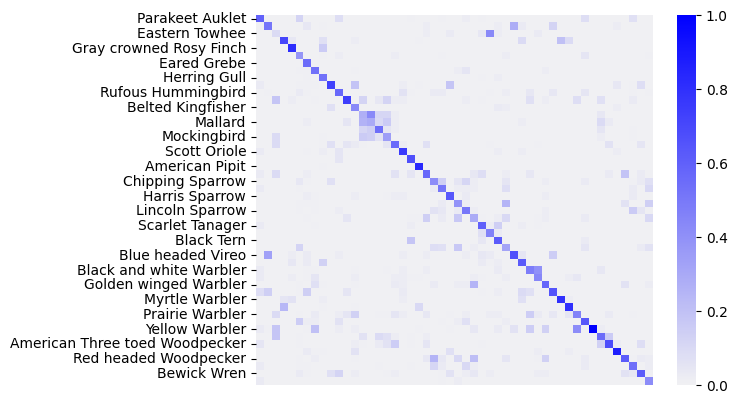

In [60]:
# plot the confusion matrix with precision on the diagonal
import seaborn as sn
import matplotlib.pyplot as plt

# prepare the labels
labs = np.array(get_list_of_classes(class_names, 'CUB'))[test_labels_unseen]

# predict values
outputs_1 = np.matmul(np.matmul(test_vec.transpose(),W),test_sig)
preds_1 = np.array([np.argmax(output) for output in outputs_1])

# compute the probabilities
cf_abs = confusion_matrix(labels_test, preds_1)
cf_per = cf_abs / np.sum(cf_abs, axis=0)
mat = pd.DataFrame((cf_per).round(2), index=labs, columns=labs)

# plot the heatmap
colormap = sn.color_palette("light:b", as_cmap=True)
sn.heatmap(mat, annot=False, fmt='.0%', cmap=colormap,  xticklabels=False)

In [55]:
#predictions on unseen classes
outputs_1 = np.matmul(np.matmul(test_vec.transpose(),W),test_sig)
preds_1 = np.array([np.argmax(output) for output in outputs_1])
print(classification_report(labels_test, preds_1))
clas_rep = classification_report(labels_test, preds_1 , output_dict=True)
pd.DataFrame(clas_rep).T.to_csv(os.path.join(PATH_ASSETS, 'class_rep_unseen_awa2.csv'))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47        56
           1       0.51      0.70      0.59        60
           2       0.09      0.02      0.03        59
           3       0.71      0.45      0.55        60
           4       0.81      0.72      0.76        60
           5       0.38      0.87      0.53        60
           6       0.55      1.00      0.71        60
           7       0.53      0.85      0.65        60
           8       0.53      0.95      0.68        60
           9       0.73      0.18      0.29        60
          10       0.57      0.63      0.60        59
          11       0.74      0.23      0.35        60
          12       0.43      0.92      0.58        60
          13       0.27      0.48      0.35        50
          14       0.29      0.03      0.06        60
          15       0.54      0.64      0.59        59
          16       0.35      0.62      0.45        60
          17       0.56    

In [ ]:
#predictions on seen test classes
outputs_1 = np.matmul(np.matmul(test_s_vec.transpose(),W),test_s_sig)
preds_1 = np.array([np.argmax(output) for output in outputs_1])
print(classification_report(labels_test_s, preds_1))
clas_rep = classification_report(labels_test_s, preds_1 , output_dict=True)
pd.DataFrame(clas_rep).T.to_csv(os.path.join(PATH_ASSETS, 'class_rep_seen_awa2.csv'))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.68      0.85      0.76        20
           2       0.88      1.00      0.93         7
           3       0.92      0.92      0.92        13
           4       0.80      0.57      0.67        14
           5       1.00      0.33      0.50        12
           6       0.78      0.88      0.82         8
           7       0.78      0.88      0.82         8
           8       0.78      1.00      0.88         7
           9       0.67      0.80      0.73         5
          10       0.93      1.00      0.96        13
          11       0.40      0.73      0.52        11
          12       0.88      0.50      0.64        14
          13       0.82      0.93      0.87        15
          14       0.41      1.00      0.58        14
          15       0.62      0.71      0.67         7
          16       0.60      0.38      0.46         8
          17       0.50    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Enhance the attributes with bert embeddings

In [16]:
# extract the name of the class
def get_list_of_classes(class_names, dataset='CUB'):
    if dataset=='CUB':
        class_list = sorted([(int(cls[0][0].split('.')[0])-1, cls[0][0].split('.')[1].replace('_', ' ')) for cls in class_names])
        class_list = [tup[1] for tup in class_list]
    elif dataset=='AWA2':
        class_list = [element[0][0].replace('+', ' ') for element in class_names]
    return class_list

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# get clean names of the classes
class_list = get_list_of_classes(class_names, dataset='AWA2')

In [ ]:
# get the embeddings corresponding the the label
class_dict = dict()
for name in tqdm(class_list):
    # Tokenize the word
    tokens = tokenizer.tokenize(name)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Generate word embeddings
    input_ids = torch.tensor([input_ids])
    outputs = model(input_ids)

    # Retrieve word embedding for the [CLS] token
    embedding = outputs.last_hidden_state[:, 0, :]
    class_dict[name] = embedding
bert_attributes = np.array([emb.detach().numpy()[0] for emb in class_dict.values()])

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# reduce the dimensionality of the bert embeddings
pca = PCA(10)
bert_pca = pca.fit_transform(bert_attributes)
print('Preserved ratio of variance after applying PCA: ', sum(pca.explained_variance_ratio_))
bert_pca = (bert_pca - bert_pca.min(axis=0)) / (bert_pca.max(axis=0) - bert_pca.min(axis=0))
# concatenate bert embeddings to the original attributes
knn_att_plus = np.concatenate((knn_att, bert_pca), axis=1)
train_sig = knn_att_plus[train_labels_seen].T
trainval_sig = knn_att_plus[trainval_labels_seen].T
test_sig = knn_att_plus[test_labels_unseen].T
test_s_sig = knn_att_plus[test_labels_seen].T

Preserved ratio of variance after applying PCA:  0.5766022652387619


In [ ]:
# prepare all the needed matrices

#params for train and val set
m_train = labels_train.shape[0]
n_val = labels_val.shape[0]
z_train = len(train_labels_seen)
z1_val = len(val_labels_unseen)

#params for trainval and test set
m_trainval = labels_trainval.shape[0]
n_test = labels_test.shape[0]
z_trainval = len(trainval_labels_seen)
z1_test = len(test_labels_unseen)

#ground truth for train and val set
gt_train = 0*np.ones((m_train, z_train))
gt_train[np.arange(m_train), np.squeeze(labels_train)] = 1

#grountruth for trainval and test set
gt_trainval = 0*np.ones((m_trainval, z_trainval))
gt_trainval[np.arange(m_trainval), np.squeeze(labels_trainval)] = 1

#train set
d_train = train_vec.shape[0]
a_train = train_sig.shape[0]

#Weights
V = np.zeros((d_train,a_train))

#trainval set
d_trainval = trainval_vec.shape[0]
a_trainval = trainval_sig.shape[0]
W = np.zeros((d_trainval,a_trainval))

In [ ]:
# calculate the optimal weight matrix W
part_1_test = np.linalg.pinv(np.matmul(trainval_vec, trainval_vec.transpose()) + (10**alph1)*np.eye(d_trainval))
part_0_test = np.matmul(np.matmul(trainval_vec,gt_trainval),trainval_sig.transpose())
part_2_test = np.linalg.pinv(np.matmul(trainval_sig, trainval_sig.transpose()) + (10**gamm1)*np.eye(a_trainval))

W = np.matmul(np.matmul(part_1_test,part_0_test),part_2_test)

In [ ]:
#predictions on unseen classes
outputs_1 = np.matmul(np.matmul(test_vec.transpose(),W),test_sig)
preds_1 = np.array([np.argmax(output) for output in outputs_1])
print(classification_report(labels_test, preds_1))
clas_rep = classification_report(labels_test, preds_1 , output_dict=True)
pd.DataFrame(clas_rep).T.to_csv(os.path.join(PATH_ASSETS, 'class_rep_unseen_bert_awa2.csv'))

              precision    recall  f1-score   support

           0       0.48      0.35      0.40      1645
           1       0.10      1.00      0.18       174
           2       0.45      0.52      0.48      1420
           3       0.26      0.13      0.17       988
           4       0.41      0.21      0.27       383
           5       0.75      0.51      0.61      1202
           6       0.56      0.50      0.53       310
           7       0.88      0.35      0.50       630
           8       0.09      0.13      0.10       215
           9       0.04      0.04      0.04       946

    accuracy                           0.35      7913
   macro avg       0.40      0.37      0.33      7913
weighted avg       0.45      0.35      0.37      7913



In [ ]:
#predictions on seen test classes
outputs_1 = np.matmul(np.matmul(test_s_vec.transpose(),W),test_s_sig)
preds_1 = np.array([np.argmax(output) for output in outputs_1])
print(classification_report(labels_test_s, preds_1))
clas_rep = classification_report(labels_test_s, preds_1 , output_dict=True)
pd.DataFrame(clas_rep).T.to_csv(os.path.join(PATH_ASSETS, 'class_rep_seen_bert_awa2.csv'))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       182
           1       0.96      0.93      0.95       162
           2       1.00      0.85      0.92        60
           3       0.78      0.61      0.68        41
           4       1.00      0.96      0.98       107
           5       0.89      0.92      0.90       148
           6       0.95      0.79      0.86       218
           7       0.90      0.86      0.88       100
           8       1.00      0.94      0.97        31
           9       0.92      0.92      0.92        25
          10       1.00      1.00      1.00       175
          11       0.94      0.91      0.93       141
          12       1.00      1.00      1.00       152
          13       0.80      0.88      0.84       150
          14       0.88      0.54      0.67        54
          15       0.89      1.00      0.94       144
          16       0.96      0.99      0.98       189
          17       0.89    